# 0. Set-Up

In [32]:
# Install and import the required libraries
!pip install pathway
!pip install pathway bokeh --quiet # This cell may take a few seconds to execute.
import pandas as pd
import numpy as np
import pathway as pw
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource
from bokeh.io import push_notebook
import time
from datetime import datetime, timedelta
import math
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
# load and preview data

# files.upload()
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset.csv', index_col='ID')
df.head()

,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
ID,,,,,,,,,,,
0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


# 1. Pre-Processing

In [34]:
# @title Set numerical and categorical columns
cat_cols=['SystemCodeNumber', 'VehicleType', 'TrafficConditionNearby', 'IsSpecialDay', 'Latitude', 'Longitude'] # Set categorical columns
cols_to_encode = ['SystemCodeNumber', 'VehicleType', 'TrafficConditionNearby'] # To be encoded
num_cols = ['Capacity', 'Occupancy', 'QueueLength'] # Set numerical columns
date_time_cols = ['LastUpdatedDate', 'LastUpdatedTime'] # Date and time (string) columns

# Check which columns are under what:
print("Categorical Variables:")
print(cat_cols)
print("Numerical Variables:")
print(num_cols)
print("To Encode:")
print(cols_to_encode)
print('Date/time:')
print(date_time_cols)

Categorical Variables:
['SystemCodeNumber', 'VehicleType', 'TrafficConditionNearby', 'IsSpecialDay', 'Latitude', 'Longitude']
Numerical Variables:
['Capacity', 'Occupancy', 'QueueLength']
To Encode:
['SystemCodeNumber', 'VehicleType', 'TrafficConditionNearby']
Date/time:
['LastUpdatedDate', 'LastUpdatedTime']


Capacity
Skew : 0.59


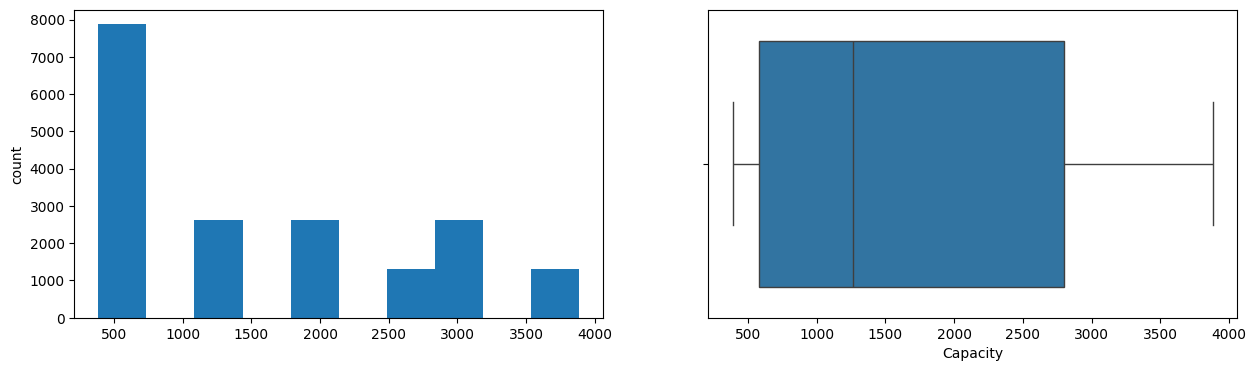

Occupancy
Skew : 2.07


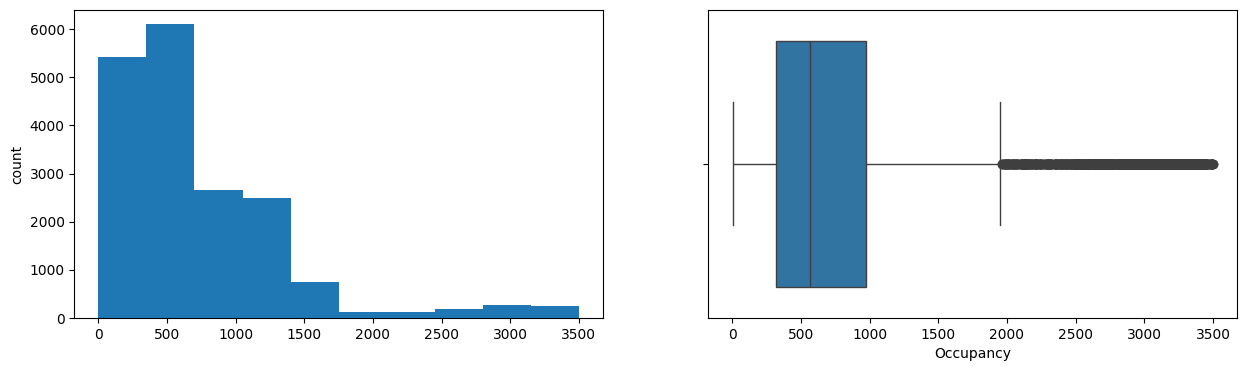

QueueLength
Skew : 0.81


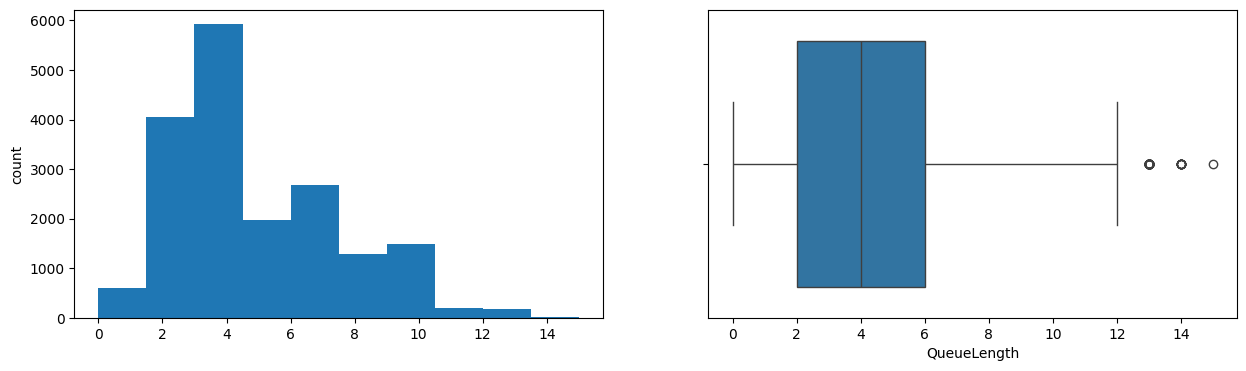

In [35]:
# @title Skew Calculation
# Calculate Skew for all numerical variables
for col in num_cols:
    print(col)
    print('Skew :', round(df[col].skew(), 2)) # rounds the skew obtained from the .skew() function from pandas
    plt.figure(figsize = (15, 4)) # sets figure size for plotting
    plt.subplot(1, 2, 1) # Specifies position of plot
    df[col].hist(grid=False) # Plots a histogram witout a grid
    plt.ylabel('count') # Sets the y-label
    plt.subplot(1, 2, 2) # Specifies position of the second plot
    sns.boxplot(x=df[col]) # makes a boxplot
    plt.show()

In [36]:
# @title Encode Columns

# Initiallise the encoded df
df_enc = df.copy()

# LabelEncode SystemCodeNumber using native factorise method.
# It wouldn't make a difference to LabelEncode since all the graphs are separated based on the SystemCodeNumber and no patterns would be detected from it.
df_enc['SystemCodeNumber_encoded'] = pd.factorize(df.SystemCodeNumber)[0]
print(df_enc.nunique()) # validate if all categories have been assigned to different numbers
print(df_enc.SystemCodeNumber_encoded.value_counts())

# One-Hot Encoding for 'VehicleType'
df_enc = pd.get_dummies(df_enc, columns=['VehicleType'], prefix='Vehicle')

# Ordinal Encoding for 'TrafficConditionNearby'
traffic_order = {'low': 0, 'average': 1, 'high': 2}
df_enc['TrafficConditionNearby_encoded'] = df_enc['TrafficConditionNearby'].map(traffic_order)
print(df_enc.TrafficConditionNearby_encoded.value_counts())

# Drop original columns
df_enc.drop(['SystemCodeNumber', 'TrafficConditionNearby'], axis=1, inplace=True)
df_enc.head()


SystemCodeNumber              14
Capacity                      14
Latitude                      14
Longitude                     14
Occupancy                   2347
VehicleType                    4
TrafficConditionNearby         3
QueueLength                   16
IsSpecialDay                   2
LastUpdatedDate               73
LastUpdatedTime              275
SystemCodeNumber_encoded      14
dtype: int64
SystemCodeNumber_encoded
0     1312
1     1312
2     1312
3     1312
4     1312
5     1312
6     1312
7     1312
8     1312
9     1312
10    1312
11    1312
12    1312
13    1312
Name: count, dtype: int64
TrafficConditionNearby_encoded
0    7793
1    6438
2    4137
Name: count, dtype: int64


,Capacity,Latitude,Longitude,Occupancy,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime,SystemCodeNumber_encoded,Vehicle_bike,Vehicle_car,Vehicle_cycle,Vehicle_truck,TrafficConditionNearby_encoded
ID,,,,,,,,,,,,,,
0,577,26.144536,91.736172,61,1,0,04-10-2016,07:59:00,0,False,True,False,False,0
1,577,26.144536,91.736172,64,1,0,04-10-2016,08:25:00,0,False,True,False,False,0
2,577,26.144536,91.736172,80,2,0,04-10-2016,08:59:00,0,False,True,False,False,0
3,577,26.144536,91.736172,107,2,0,04-10-2016,09:32:00,0,False,True,False,False,0
4,577,26.144536,91.736172,150,2,0,04-10-2016,09:59:00,0,True,False,False,False,0


In [37]:
df = df_enc.copy() # set the original df to the encoded df
df

,Capacity,Latitude,Longitude,Occupancy,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime,SystemCodeNumber_encoded,Vehicle_bike,Vehicle_car,Vehicle_cycle,Vehicle_truck,TrafficConditionNearby_encoded
ID,,,,,,,,,,,,,,
0,577,26.144536,91.736172,61,1,0,04-10-2016,07:59:00,0,False,True,False,False,0
1,577,26.144536,91.736172,64,1,0,04-10-2016,08:25:00,0,False,True,False,False,0
2,577,26.144536,91.736172,80,2,0,04-10-2016,08:59:00,0,False,True,False,False,0
3,577,26.144536,91.736172,107,2,0,04-10-2016,09:32:00,0,False,True,False,False,0
4,577,26.144536,91.736172,150,2,0,04-10-2016,09:59:00,0,True,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18363,1920,26.150504,91.733531,1517,6,0,19-12-2016,14:30:00,13,False,False,False,True,1
18364,1920,26.150504,91.733531,1487,3,0,19-12-2016,15:03:00,13,False,True,False,False,0
18365,1920,26.150504,91.733531,1432,3,0,19-12-2016,15:29:00,13,False,False,True,False,0


In [38]:
# Combine the 'LastUpdatedDate' and 'LastUpdatedTime' columns into a single datetime column
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
                                  format='%d-%m-%Y %H:%M:%S')

# Sort the DataFrame by the new 'Timestamp' column and reset the index
df = df.sort_values('Timestamp').reset_index(drop=True)

# Drop the original Date/time columns
df.drop(["LastUpdatedDate","LastUpdatedTime"], axis=1, inplace=True)

# 2. Pathway Pipeline Processing

In [39]:
# Save the selected columns to a CSV file for streaming or downstream processing
df.to_csv("parking_stream.csv", index=False)
df.head()

,Capacity,Latitude,Longitude,Occupancy,QueueLength,IsSpecialDay,SystemCodeNumber_encoded,Vehicle_bike,Vehicle_car,Vehicle_cycle,Vehicle_truck,TrafficConditionNearby_encoded,Timestamp
0,577,26.144536,91.736172,61,1,0,0,False,True,False,False,0,2016-10-04 07:59:00
1,1200,26.140014,91.731000,237,2,0,4,True,False,False,False,0,2016-10-04 07:59:00
2,687,20.000035,78.000003,264,2,0,3,False,True,False,False,0,2016-10-04 07:59:00
3,485,26.140048,91.730972,249,2,0,5,False,True,False,False,0,2016-10-04 07:59:00
4,1920,26.150504,91.733531,614,2,0,13,False,False,True,False,0,2016-10-04 07:59:00


In [40]:
# @title Pathway Schema
# Define the schema for the streaming data using Pathway
# This schema specifies the expected structure of each data row in the stream

class ParkingSchema(pw.Schema):
    Capacity: int    # Total parking capacity at the location
    Latitude: float  # Latitude of the location (may influence rates)
    Longitude: float # Longitude of the location (may influence rates)
    Occupancy: int   # Number of occupied parking spots
    QueueLength: int # Length of queue
    IsSpecialDay: int # If the day is a holiday
    SystemCodeNumber_encoded: int  # The encoded SystemCodeNumber
    Vehicle_bike: bool  # Encoded Vehicle column for bikes
    Vehicle_car: bool   # Encoded Vehicle column for cars
    Vehicle_cycle: bool # Encoded Vehicle column for cycles
    Vehicle_truck: bool # Encoded Vehicle column for trucks
    TrafficConditionNearby_encoded: int # Encoded column for the traffic condition
    Timestamp: str   # Timestamp of the observation


In [41]:
# @title Demo Replay
# Load the data as a simulated stream using Pathway's replay_csv function
# This replays the CSV data at a controlled input rate to mimic real-time streaming
# input_rate=1000 means approximately 1000 rows per second will be ingested into the stream.

data = pw.demo.replay_csv("parking_stream.csv",
                          schema=ParkingSchema, input_rate=1312)

In [42]:
# @title Format Datetime
# Define the datetime format to parse the 'Timestamp' column
fmt = "%Y-%m-%d %H:%M:%S"

# Add new columns to the data stream:
# - 't' contains the parsed full datetime
# - 'day' extracts the date part and resets the time to midnight (useful for day-level aggregations)
data_with_time = data.with_columns(
    t = data.Timestamp.dt.strptime(fmt),
    day = data.Timestamp.dt.strptime(fmt).dt.strftime("%Y-%m-%dT00:00:00")
)


# 3. The Pricing Functions

In [43]:
# @title Sample Pricing
# delta_window = (
#     data_with_time.windowby(
#         pw.this.t,  # Event time column to use for windowing (parsed datetime)
#         instance=pw.this.day,  # Logical partitioning key: one instance per calendar day
#         window=pw.temporal.tumbling(datetime.timedelta(days=1)),  # Fixed-size daily window
#         behavior=pw.temporal.exactly_once_behavior()  # Guarantees exactly-once processing semantics
#     )
#     .reduce(
#         t=pw.this._pw_window_end,                        # Assign the end timestamp of each window
#         occ_max=pw.reducers.max(pw.this.Occupancy),      # Highest occupancy observed in the window
#         occ_min=pw.reducers.min(pw.this.Occupancy),      # Lowest occupancy observed in the window
#         cap=pw.reducers.max(pw.this.Capacity),           # Maximum capacity observed (typically constant per spot)
#     )
#     .with_columns(
#         # Compute the price using a simple dynamic pricing formula:
#         #
#         # Pricing Formula:
#         #     price = base_price + demand_fluctuation
#         #     where:
#         #         base_price = 10 (fixed minimum price)
#         #         demand_fluctuation = (occ_max - occ_min) / cap
#         #
#         # Intuition:
#         # - The greater the difference between peak and low occupancy in a day,
#         #   the more volatile the demand is, indicating potential scarcity.
#         # - Dividing by capacity normalizes the fluctuation (to stay in [0,1] range).
#         # - This fluctuation is added to the base price of 10 to set the final price.
#         # - Example: If occ_max = 90, occ_min = 30, cap = 100
#         #            => price = 10 + (90 - 30)/100 = 10 + 0.6 = 10.6

#         price = 10 + (pw.this.occ_max - pw.this.occ_min) / pw.this.cap
#     )
# )

In [44]:
# @title Baseline Pricing Model with cap/floor
import datetime

# 1. Modify Baseline Pricing Model
#    Remove demand-pressure logic. Replace with:
#    Pricet+1 = Pricet + alpha * (Occupancy / Capacity)
intermediate = (
    data_with_time.windowby(
        pw.this.t,
        instance=pw.this.SystemCodeNumber_encoded, # To separate based on the system code number
        window=pw.temporal.tumbling(datetime.timedelta(days=1)), # Define a tumbling window with 1 day
                                                                # as the time interval to make the graph readable
        behavior=pw.temporal.exactly_once_behavior() # Exactly-once enable
    )
    .reduce(
        t=pw.this._pw_window_end,
        current_occupancy=pw.reducers.max(pw.this.Occupancy), # set occupancy
        current_capacity=pw.reducers.max(pw.this.Capacity), # Set capacity
        system_code=pw.reducers.max(pw.this.SystemCodeNumber_encoded) # set system code
    )
    .with_columns(
        occupancy_ratio=pw.apply(
            lambda occ, cap: occ / max(cap, 1), #calculate occupancy ratio as occupancy/capacity and 1 to avoid missing values for capacity
            pw.this.current_occupancy,
            pw.this.current_capacity
        )
    )
)

baseline_pricing = intermediate.with_columns(
    price=pw.apply(
        lambda r: max(5.0, min(20.0, 10.0 + 4.0 * r)), # apply the linear function with 5 to be min price and 20 to be max, where the equation is base price + 4*adjustment
        pw.this.occupancy_ratio
    )
)

In [45]:
# @title Demand-Based Pricing
demand_model = (
    data_with_time.windowby(
        pw.this.t,
        instance=pw.this.SystemCodeNumber_encoded,
        window=pw.temporal.tumbling(datetime.timedelta(days=1)),
        behavior=pw.temporal.exactly_once_behavior()
    )
    .reduce(
        t=pw.this._pw_window_end,
        current_occupancy=pw.reducers.max(pw.this.Occupancy),
        current_capacity=pw.reducers.max(pw.this.Capacity),
        current_queue=pw.reducers.max(pw.this.QueueLength),
        is_special_day=pw.reducers.max(pw.this.IsSpecialDay),
        vehicle_truck=pw.reducers.max(pw.this.Vehicle_truck),
        vehicle_car=pw.reducers.max(pw.this.Vehicle_car),
        vehicle_bike=pw.reducers.max(pw.this.Vehicle_bike),
        vehicle_cycle=pw.reducers.max(pw.this.Vehicle_cycle),
        traffic_condition=pw.reducers.max(pw.this.TrafficConditionNearby_encoded),
        system_code=pw.reducers.max(pw.this.SystemCodeNumber_encoded)
    )
)

demand_model = demand_model.with_columns(
    occupancy_ratio=pw.apply(lambda occ, cap: occ / max(cap, 1),
                             pw.this.current_occupancy, pw.this.current_capacity)
)
demand_model = demand_model.with_columns(
    queue_pressure=pw.apply(lambda q: (math.exp(2*q/5.0) - 1) / (math.exp(2*q/5.0) + 1) * 0.3,
                            pw.this.current_queue)
)
demand_model = demand_model.with_columns(
    traffic_multiplier=pw.apply(lambda traffic: 1 + (traffic / 2.0) * 0.2,
                                pw.this.traffic_condition)
)
demand_model = demand_model.with_columns(
    vehicle_premium=pw.apply(lambda truck, car, bike, cycle:
                             truck * 0.25 + car * 0.0 + bike * (-0.15) + cycle * (-0.20),
                             pw.this.vehicle_truck, pw.this.vehicle_car,
                             pw.this.vehicle_bike, pw.this.vehicle_cycle)
)
demand_model = demand_model.with_columns(
    special_day_surge=pw.apply(lambda special: special * 0.3,
                               pw.this.is_special_day)
)
demand_model = demand_model.with_columns(
    core_demand=pw.apply(lambda ratio: 1.0 / (1.0 + math.exp(-6 * (ratio - 0.5))),
                         pw.this.occupancy_ratio)
)
demand_model = demand_model.with_columns(
    total_demand=pw.apply(lambda core, queue, special, traffic:
                          core * 0.5 + queue * 0.2 + special * 0.15 + (traffic - 1) * 0.15,
                          pw.this.core_demand, pw.this.queue_pressure,
                          pw.this.special_day_surge, pw.this.traffic_multiplier)
)
demand_model = demand_model.with_columns(
    raw_price=pw.apply(lambda demand, vehicle:
                       10.0 * (1 + demand) * (1 + vehicle),
                       pw.this.total_demand, pw.this.vehicle_premium)
)
demand_based_pricing = demand_model.with_columns(
    price=pw.apply(lambda raw:
                   5.0 + 15.0 / (1.0 + math.exp(-2 * (raw - 12.5))),
                   pw.this.raw_price)
)



In [46]:
# @title Competitive (optional) - Single plot
import datetime
import pathway as pw

# Model 3: Competitive Pricing Model
competitive_pricing = (
    data_with_time.windowby(
        pw.this.t,  # Event time column (parsed datetime)
        instance=pw.this.day,  # One instance per calendar day
        window=pw.temporal.tumbling(datetime.timedelta(days=1)),  # 1-hour windows
        behavior=pw.temporal.exactly_once_behavior()  # Exactly-once processing
    )
    .reduce(
        t=pw.this._pw_window_end,                           # Window end timestamp
        current_occupancy=pw.reducers.max(pw.this.Occupancy),
        current_capacity=pw.reducers.max(pw.this.Capacity),
        current_queue=pw.reducers.max(pw.this.QueueLength),
        is_special_day=pw.reducers.max(pw.this.IsSpecialDay),
        vehicle_truck=pw.reducers.max(pw.this.Vehicle_truck),
        vehicle_car=pw.reducers.max(pw.this.Vehicle_car),
        vehicle_bike=pw.reducers.max(pw.this.Vehicle_bike),
        vehicle_cycle=pw.reducers.max(pw.this.Vehicle_cycle),
        traffic_condition=pw.reducers.max(pw.this.TrafficConditionNearby_encoded),
        latitude=pw.reducers.max(pw.this.Latitude),
        longitude=pw.reducers.max(pw.this.Longitude),
        system_code=pw.reducers.max(pw.this.SystemCodeNumber_encoded),
        # Competitor data for nearby lots (simplified - getting averages)
        avg_competitor_occupancy=pw.reducers.avg(pw.this.Occupancy),
        avg_competitor_capacity=pw.reducers.avg(pw.this.Capacity),
    )
    .with_columns(
        # Step 1: Calculate occupancy ratio
        occupancy_ratio=pw.apply(
            lambda occ, cap: occ / max(cap, 1),
            pw.this.current_occupancy,
            pw.this.current_capacity
        )
    )
    .with_columns(
        # Step 2: Calculate queue pressure using tanh
        queue_pressure=pw.apply(
            lambda q: (pow(2.718281828, 2*q/5.0) - 1) / (pow(2.718281828, 2*q/5.0) + 1) * 0.3,
            pw.this.current_queue
        )
    )
    .with_columns(
        # Step 3: Calculate traffic multiplier
        traffic_multiplier=pw.apply(
            lambda traffic: 1 + (traffic / 2.0) * 0.2,
            pw.this.traffic_condition
        )
    )
    .with_columns(
        # Step 4: Calculate vehicle premium
        vehicle_premium=pw.apply(
            lambda truck, car, bike, cycle: truck * 0.25 + car * 0.0 + bike * (-0.15) + cycle * (-0.20),
            pw.this.vehicle_truck,
            pw.this.vehicle_car,
            pw.this.vehicle_bike,
            pw.this.vehicle_cycle
        )
    )
    .with_columns(
        # Step 5: Calculate special day surge
        special_day_surge=pw.apply(
            lambda special: special * 0.3,
            pw.this.is_special_day
        )
    )
    .with_columns(
        # Step 6: Calculate core demand using sigmoid
        core_demand=pw.apply(
            lambda ratio: 1.0 / (1.0 + pow(2.718281828, -6 * (ratio - 0.5))),
            pw.this.occupancy_ratio
        )
    )
    .with_columns(
        # Step 7: Calculate total demand (reduced weight for core_demand to make room for competitive factors)
        total_demand=pw.apply(
            lambda core, queue, special, traffic: core * 0.4 + queue * 0.2 + special * 0.15 + (traffic - 1) * 0.15,
            pw.this.core_demand,
            pw.this.queue_pressure,
            pw.this.special_day_surge,
            pw.this.traffic_multiplier
        )
    )
    .with_columns(
        # Step 8: Estimate competitor price based on regional average
        # competitor_occupancy_ratio = avg_competitor_occupancy / avg_competitor_capacity
        competitor_occupancy_ratio=pw.apply(
            lambda avg_occ, avg_cap: avg_occ / max(avg_cap, 1),
            pw.this.avg_competitor_occupancy,
            pw.this.avg_competitor_capacity
        )
    )
    .with_columns(
        # Step 9: Calculate estimated competitor price
        # competitor_price = base_price * (1 + competitor_occupancy_ratio * 0.5)
        estimated_competitor_price=pw.apply(
            lambda comp_ratio: 10.0 * (1 + comp_ratio * 0.5),
            pw.this.competitor_occupancy_ratio
        )
    )
    .with_columns(
        # Step 10: Calculate base competitive price (before competitive adjustment)
        base_competitive_price=pw.apply(
            lambda demand, vehicle: 10.0 * (1 + demand) * (1 + vehicle),
            pw.this.total_demand,
            pw.this.vehicle_premium
        )
    )
    .with_columns(
        # Step 11: Calculate competitive factor
        # If occupancy > 80%: premium pricing vs competitors
        # If occupancy <= 80%: slightly undercut competitors
        competitive_factor=pw.apply(
            lambda occ_ratio, base_price, comp_price:
                (0.95 if comp_price < base_price else 1.05) if occ_ratio > 0.8
                else (0.98 if comp_price > base_price else 1.02),
            pw.this.occupancy_ratio,
            pw.this.base_competitive_price,
            pw.this.estimated_competitor_price
        )
    )
    .with_columns(
        # Step 12: Apply competitive adjustment
        competitive_price=pw.apply(
            lambda base_price, factor: base_price * factor,
            pw.this.base_competitive_price,
            pw.this.competitive_factor
        )
    )
    .with_columns(
        # Step 13: Determine dynamic max price based on market pressure
        # market_pressure = occupancy_ratio * queue_pressure
        market_pressure=pw.apply(
            lambda occ_ratio, queue: occ_ratio * queue,
            pw.this.occupancy_ratio,
            pw.this.queue_pressure
        )
    )
    .with_columns(
        # Step 14: Calculate final bounded price
        # High market pressure allows higher max price (22), otherwise 18
        price=pw.apply(
            lambda comp_price, market_press:
                max(4.0, min(22.0 if market_press > 0.7 else 18.0, comp_price)),
            pw.this.competitive_price,
            pw.this.market_pressure
        )
    )
)


In [49]:
# @title Plot Initiallisation
import bokeh.plotting
import panel as pn
# Activate the Panel extension to enable interactive visualizations
pn.extension()

# Define a custom Bokeh plotting function that takes a data source (from Pathway) and returns a figure

# Single Graph Price plotter
def price_plotter(source):
    # Create a Bokeh figure with datetime x-axis
    fig = bokeh.plotting.figure(
        height=400,
        width=800,
        title="Pathway: Daily Parking Price",
        x_axis_type="datetime",  # Ensure time-based data is properly formatted on the x-axis
    )
    # Plot a line graph showing how the price evolves over time
    fig.line("t", "price", source=source, line_width=2, color="navy")

    # Overlay red circles at each data point for better visibility
    fig.circle("t", "price", source=source, size=6, color="red")

    return fig

# 2. Filter and Plot One Graph per SystemCodeNumber
plot_dict = {}
valid_codes = df['SystemCodeNumber_encoded'].unique()  # avoid blanks for missing codes
for code in valid_codes:
    print(f"Generating plot for SystemCodeNumber_encoded = {code}")
    filtered = baseline_pricing.filter(pw.this.system_code == code)
    viz = filtered.plot(price_plotter, sorting_col="t")
    plot_dict[code] = viz

import bokeh.plotting
import bokeh.models
import bokeh.layouts

# Create a Panel layout and make it servable as a web app
# This line enables the interactive plot to be displayed when the app is served
# 4. Use `pn.Column(*plot_dict.values()).servable()` to display all plots
layout = pn.Column(*plot_dict.values())
layout.servable()

Generating plot for SystemCodeNumber_encoded = 0
Generating plot for SystemCodeNumber_encoded = 4


Generating plot for SystemCodeNumber_encoded = 3
Generating plot for SystemCodeNumber_encoded = 5


Generating plot for SystemCodeNumber_encoded = 13
Generating plot for SystemCodeNumber_encoded = 2


Generating plot for SystemCodeNumber_encoded = 6
Generating plot for SystemCodeNumber_encoded = 11


Generating plot for SystemCodeNumber_encoded = 7
Generating plot for SystemCodeNumber_encoded = 8


Generating plot for SystemCodeNumber_encoded = 1
Generating plot for SystemCodeNumber_encoded = 9


Generating plot for SystemCodeNumber_encoded = 10
Generating plot for SystemCodeNumber_encoded = 12


Column
    [0] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [1] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [2] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [3] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [4] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [5] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [6] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [7] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [8] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [9] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [10] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [11] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [12] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [13] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)

In [48]:
# Use Pathway's built-in .plot() method to bind the data stream (delta_window) to the Bokeh plot
# - 'price_plotter' is the rendering function
# - 'sorting_col="t"' ensures the data is plotted in time order
# viz = competitive_pricing.plot(price_plotter, sorting_col="t")

plot_dict_demand = {}
valid_codes = df['SystemCodeNumber_encoded'].unique()  # avoid blanks for missing codes
for code in valid_codes:
    print(f"Generating plot for SystemCodeNumber_encoded = {code}")
    filtered = demand_model.filter(pw.this.system_code == code)
    viz = filtered.plot(price_plotter, sorting_col="t")
    plot_dict_demand[code] = viz

import bokeh.plotting
import bokeh.models
import bokeh.layouts

# Create a Panel layout and make it servable as a web app
# This line enables the interactive plot to be displayed when the app is served
# 4. Use `pn.Column(*plot_dict_demand.values()).servable()` to display all plots
# layout = pn.Column(*plot_dict_demand.values())
# layout.servable()



Generating plot for SystemCodeNumber_encoded = 0


Generating plot for SystemCodeNumber_encoded = 4
Generating plot for SystemCodeNumber_encoded = 3


Generating plot for SystemCodeNumber_encoded = 5


Generating plot for SystemCodeNumber_encoded = 13


Generating plot for SystemCodeNumber_encoded = 2


Generating plot for SystemCodeNumber_encoded = 6


Generating plot for SystemCodeNumber_encoded = 11


Generating plot for SystemCodeNumber_encoded = 7


Generating plot for SystemCodeNumber_encoded = 8


Generating plot for SystemCodeNumber_encoded = 1


Generating plot for SystemCodeNumber_encoded = 9


Generating plot for SystemCodeNumber_encoded = 10


Generating plot for SystemCodeNumber_encoded = 12


Column
    [0] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [1] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [2] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [3] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [4] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [5] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [6] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [7] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [8] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [9] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [10] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [11] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [12] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [13] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)

 4. Run

In [ ]:
%%capture --no-display
pw.run()

Output()